In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
s = 1


In [2]:
data = pd.read_csv("/home/oskar/Desktop/fagprojekt/compas/compas-scores-raw.csv")
# Til at se på dataen 
#print(data.head)
#print(data.columns)

# Check if there are any missing values
print(np.count_nonzero(data["IsDeleted"] == 1))

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


0
No GPU available.


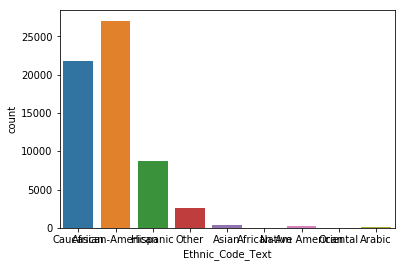

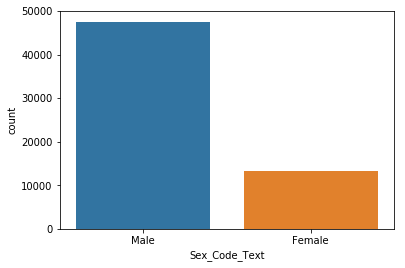

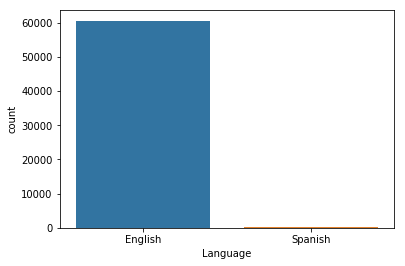

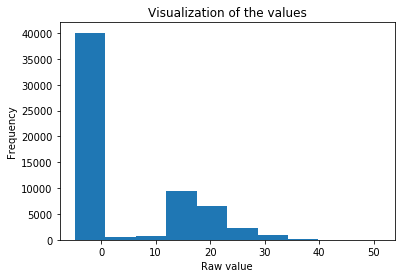

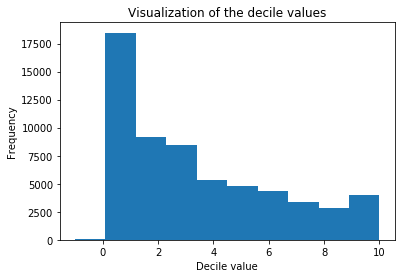

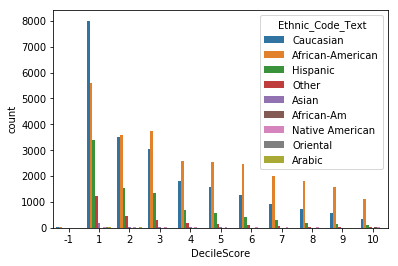

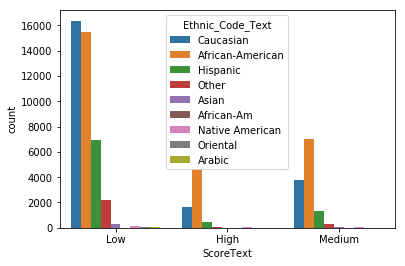

In [3]:
def plots():
    # Show distribution of different ethnicities and sexes
    sb.countplot(x = "Ethnic_Code_Text", data = data)
    plt.show()
    sb.countplot(x = "Sex_Code_Text", data = data)
    plt.show()
    sb.countplot(x = "Language", data = data)
    plt.show()
    
    # Showing the distribution of the raw and decile values
    plt.xlabel("Raw value")
    plt.ylabel("Frequency")
    plt.title("Visualization of the values")
    plt.hist(data["RawScore"])
    plt.show()
    
    plt.xlabel("Decile value")
    plt.ylabel("Frequency")
    plt.title("Visualization of the decile values")
    plt.hist(data["DecileScore"])
    plt.show()
    
    
    #sb.countplot(x = "RawScore", hue = "Ethnic_Code_Text", data = data)
    #plt.show()
    
    # Indication that some black people might get higher sentences that white people
    sb.countplot(x = "DecileScore", hue = "Ethnic_Code_Text", data = data)
    plt.show()
    
    sb.countplot(x = "ScoreText", hue = "Ethnic_Code_Text", data = data)
    plt.show()
plots()

### DATA PRE-PROCESSING AND PREPARATION ###

In [4]:
categoricals = ["Agency_Text", "Sex_Code_Text", "Ethnic_Code_Text", "ScaleSet_ID", "AssessmentReason", "Language", "LegalStatus", "CustodyStatus", "MaritalStatus", "RecSupervisionLevel"]
# Changing date of birth into age,as this should work better in a neural network
if s == 1:
    ages = [None] * len(data["DateOfBirth"])
    for i in range(len(data["DateOfBirth"])):
        ages[i] = 20 +(100 - int(data["DateOfBirth"][i].split("/")[2]))
    data["DateOfBirth"] = ages
    numericals = ["DateOfBirth"]
    s+=1
else:
    pass

outputs = ["ScoreText"]
print(data[outputs])
print(data.shape)
data = data.dropna(axis = 0, how = 'any')
print(data.shape)
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',2)
data[outputs] = data[outputs].astype("category")
#outputs = ["DecileScore"]
#data["DecileScore"] = data["DecileScore"].replace(-1, 0)
#data["DecileScore"] = data["DecileScore"].astype("category")
#print(data["DecileScore"].cat.categories)

for category in categoricals:
    data[category] = data[category].astype("category")

      ScoreText
0           Low
1           Low
2           Low
3           Low
4           Low
5           Low
6          High
7          High
8           Low
9        Medium
10       Medium
11          Low
12          Low
13          Low
14          Low
15       Medium
16         High
17       Medium
18          Low
19          Low
20          Low
21       Medium
22         High
23          Low
24          Low
25          Low
26          Low
27          Low
28          Low
29          Low
...         ...
60813    Medium
60814      High
60815      High
60816    Medium
60817      High
60818       Low
60819       Low
60820      High
60821      High
60822       Low
60823    Medium
60824    Medium
60825    Medium
60826    Medium
60827    Medium
60828    Medium
60829    Medium
60830       Low
60831       Low
60832    Medium
60833      High
60834       Low
60835       Low
60836       Low
60837       Low
60838      High
60839      High
60840       Low
60841    Medium
60842       Low

[60843 

In [5]:

# Preparing data for pytorch
Xcat = []
for i in range(len(categoricals)):
    Xcat.append(data[categoricals[i]].cat.codes.values)
Xcat = torch.tensor(Xcat , dtype = torch.int64).T
#Converting the numerical values to a tensor
Xnum = np.stack([data[col].values for col in numericals], 1)
Xnum = torch.tensor(Xnum, dtype=torch.float)

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = y[totalnumber - testnumber:totalnumber]



In [6]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.softmax(x, dim = -1 )

In [7]:
# Define and show the model
model = Model(categorical_embedding_sizes, 1, 3, [8,16,32,64,128], p=0.6)
if use_cuda:
    model.cuda()
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(2, 1)
    (2): Embedding(9, 5)
    (3): Embedding(2, 1)
    (4): Embedding(1, 1)
    (5): Embedding(2, 1)
    (6): Embedding(5, 3)
    (7): Embedding(6, 3)
    (8): Embedding(7, 4)
    (9): Embedding(4, 2)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (batch_norm_num): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.6, inplace=False)
    (8): Linear(in_features=16, out_features=32, bias=True)
    (9): ReLU(inplace=True)
    (10): Batc

In [8]:
# Loss function and optimization
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 , weight_decay = 1e-6)

epoch:   1 loss: 1.11468101
epoch:  26 loss: 1.01834166
epoch:  51 loss: 0.95189774
epoch:  76 loss: 0.92357290
epoch: 101 loss: 0.91016585
epoch: 126 loss: 0.89746469
epoch: 151 loss: 0.89116299
epoch: 176 loss: 0.88612604
epoch: 201 loss: 0.88116086
epoch: 226 loss: 0.88349169
epoch: 251 loss: 0.88228744
epoch: 276 loss: 0.87748611
epoch: 300 loss: 0.8741175532
[[2077    4    0]
 [ 659    8    0]
 [ 379    0    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2081
           1       0.67      0.01      0.02       667
           2       0.00      0.00      0.00       379

   micro avg       0.67      0.67      0.67      3127
   macro avg       0.44      0.34      0.27      3127
weighted avg       0.59      0.67      0.54      3127

0.6667732651103294


/home/oskar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oskar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/oskar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


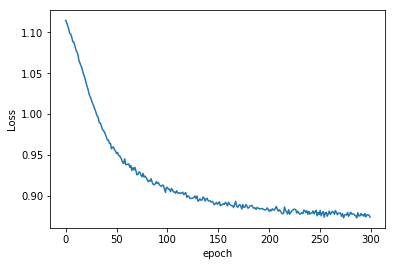

In [9]:
epochs = 300
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain)
    aggregated_losses.append(single_loss)
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    


# Plot the loss over epocs
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest)


y_val = np.argmax(y_val, axis=1)


print(confusion_matrix(ytest,y_val))
print(classification_report(ytest,y_val))
print(accuracy_score(ytest, y_val))